 Simulation with the prediction block using persistence of the previous day as prediction method

#### $\hspace{15px}$ $\tilde{X}(k) = X(k-1)$, 
#### $\hspace{15px}$ $\tilde{Y}(k) = Y(k-1)$, 


Maximum voltage rise $vm_{pu}^{max} = 1.0250$

---

#### Import Modules 


In [1]:
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt
import numpy as np
import ipyparallel as ipp
import math as mt
from tqdm import tqdm # Profiling 
import seaborn as sbn
import pickle, sys, importlib,  time
import os
from pickle import load
import tensorflow as tf
import joblib

In [2]:
function_folder = 'py_files/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

import oriFunctions as oriFc
from oriFunctions import network_folder, excel_folder, py_folder, Δt, attr_list

#### Import Networks


In [3]:
net_civaux=pp.from_pickle(f'{network_folder}CIVAUX.p')
net_stlaurent=pp.from_pickle(f'{network_folder}ST LAURENT.p')

# Compute the total of BT prod and Load on St Laurent
sum_max_p_mw_StLaurent_prodBT =net_stlaurent.sgen[net_stlaurent.sgen.name.isna()].max_p_mw.sum()
sum_max_p_mw_StLaurent_load = net_stlaurent.load.max_p_mw.sum()

# To use later in functions 
sum_max_main_network = (sum_max_p_mw_StLaurent_prodBT, sum_max_p_mw_StLaurent_load)


#### Import and dataClead files for component of the network

In [4]:
#Load files
file_p_inj_0013 = 'Prod_HTA/PROD_Bis/P0013/PROD-BATISOLAIRE 6-CIVAUX - Actif injecte (P-).csv'
file_p_inj_0018 = 'Prod_HTA/PROD_Bis/P0018/PROD-SUN POITOU 2516 (Z.I de la Pitage)-LHOMMAIZE - Actif injecte (P-).csv'


# The  commissioning of the Prod P0100 is recent (2022). I therefore use the data of the closer energy 
# producer that is P0058  and consider it as that of Prod P0100 
file_p_inj_0100 = 'Prod_HTA/PROD_Bis/PROD-SERGIES 2204 (LA ROCHE A CORNUCHON)-PINDRAY - Actif P-.csv'

file_prod_bt_total = 'PROD_BTSUP36_SAINT LAURENT.csv'
file_cons_total = 'CONSO_POSTE_SAINT LAURENT.csv'


# Get files data 
p_mw_0013 = oriFc.readAndReshape_excelFile(file_p_inj_0013 ,excel_folder, )
p_mw_0018 = oriFc.readAndReshape_excelFile(file_p_inj_0018 ,excel_folder,)
p_mw_0100 = oriFc.readAndReshape_excelFile(file_p_inj_0100 ,excel_folder,)


p_mw_prod_bt_total = oriFc.readAndReshape_excelFile(file_prod_bt_total, excel_folder)
p_mw_cons_total = oriFc.readAndReshape_excelFile(file_cons_total, excel_folder)

# Create dict for all HT producers
dict_prod_hv = {'P0013': p_mw_0013[:len(p_mw_0100)], 
                'P0018': p_mw_0018[:len(p_mw_0100)],
                'P0100': p_mw_0100[:len(p_mw_0100)]
               }
# Create index to use for dataframe
per_index = pd.period_range('01 01 2020', periods=len(p_mw_0100), freq='10T')

# Use the create dict to create a dataFrame for Prod P0100
df_prodP0100 = pd.DataFrame(p_mw_0100, index=per_index)

# Use the create dict to create a dataFrame for all HT producers
df_prodHT = pd.DataFrame(dict_prod_hv, index=per_index)

# Dataframe prod BT 
per_index = pd.period_range('01 01 2020', periods=len(p_mw_prod_bt_total), freq='10T')
df_prod_bt_total = pd.DataFrame(p_mw_prod_bt_total, index=per_index, columns=['Prod_BT'])


# Dataframe Conso BT 
per_index = pd.period_range('01 01 2020', periods=len(p_mw_cons_total), freq='10T')
df_cons_total = pd.DataFrame(p_mw_cons_total, index=per_index, columns=['Cons'])
# Data cleaning on Consumption
previous_days = df_cons_total[(per_index>='2022 02 12') & (per_index<='2022 02 21 23:50')]
following_days = df_cons_total[(per_index>='2022 03 03') & (per_index<='2022 03 12 23:50')]
# # Put the interpolated data into the dataframe
df_cons_total[(per_index>='2022 02 21') & (per_index<='2022 03 02 23:50')] = (np.array(following_days) + 
                                                                              np.array(previous_days) )/2


# Get total Power of BT producers
# Bt producers are indexed by the name None
max_p_mw_total_prodBT = net_civaux.sgen.max_p_mw[net_civaux.sgen.name.isna()].sum()

# # Get total power of load in the network
max_p_mw_total_load = net_civaux.load.max_p_mw.sum()

# Select relevant data up to 2022 06 01
df_prodHT = df_prodHT[df_prodHT.index<='2022 06 01 23:50']
df_prod_bt_total = df_prod_bt_total[df_prod_bt_total.index<='2022 06 01 23:50']
df_cons_total = df_cons_total[df_cons_total.index<='2022 06 01 23:50']


# Extract only dailight period i.e. from 07am to 7PM
# The daylight period is considered to be defined betwenn 07am and 7Pm excluded. 
h_start_end = ('06:50','18:50') # for the persistance model, the previous period i.e. 06:50 
                                # is needed to compute the first instant i.e. 07:00
per_index = df_prodHT.index
per_daylight = ( pd.Series(index=per_index.to_timestamp(), dtype=object).between_time(*h_start_end) ).index.to_period('10T')
day_tot_per = len(per_daylight[(per_daylight.year==2020)&(per_daylight.month==1)&(per_daylight.day==1)])


# Put all the data in a unique dataframe
df_data = pd.concat([df_cons_total, df_prod_bt_total, df_prodHT], axis=1).loc[per_daylight]

# # Extract only the relavant testing set since the training set covers the first part of the data
df_final = df_data[df_data.index>='2021 06 01']
per_index = df_final.index
per_index2 = ( pd.Series(index=per_index.to_timestamp(), dtype=object
                           ).between_time('07:00','18:50') ).index.to_period('10T')


#### Data extraction on the network

In [5]:
net_civaux_hv_bus = list(net_civaux.bus.groupby('vn_kv'))[1][1] # Extract HV bus in the network

pp.runpp(net_civaux) # Run network 

# Get the index of all the activated bus in the network
activated_bus_index = list(net_civaux.res_bus.vm_pu[net_civaux.res_bus.vm_pu.notna()].index)

# Extract the HV bus from the list of activated bus 
net_civaux_hv_activated_bus = [i for i in activated_bus_index 
                               if i in net_civaux_hv_bus.index]

# redefine data given final dataframe
df_prodHT = df_final[['P0013','P0018','P0100']] 
df_prod_bt_total = df_final[['Prod_BT']]
df_cons_total = df_final[['Cons']]

# Define a dict 
dict_df_sgenLoad = dict({'df_prodHT':df_prodHT, 
                         'df_prod_bt_total':df_prod_bt_total, 
                         'df_cons_total':df_cons_total } )

#### Create daylight period mask 

In [6]:
daylight_mask = (df_prodHT.P0013>0)|(df_prodHT.P0018>0)|(df_prodHT.P0100>0)|(df_prod_bt_total.Prod_BT>0)

#### Start Parallel engines

In [7]:
n_engines = 6  # Total number of engines
# (Use the real maximum cpu and not the logical)            
cluster = ipp.Cluster(n=n_engines) # Create cluster
cluster.start_cluster_sync()       # Start cluster 
rc = cluster.connect_client_sync() # connect client
rc.wait_for_engines(n_engines)     # Wait for engines to be available for all clients
dview = rc[:]                      # Create a direct view of all engine or clients that would
                                   # be used to command each client

Starting 6 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/6 [00:00<?, ?engine/s]

## OPF Persistence Model 

#### Load network

In [8]:
net_civaux=pp.from_pickle(f'{network_folder}CIVAUX.p') # Reload network with new name 

# Add a controllable line to the static generators
net_civaux.sgen['controllable'] = False 

# Set the producer P0100 as a controllable load
net_civaux.sgen['controllable'][net_civaux.sgen.name=='P0100'] = True

# Add Missing columns to be able to un an opf 
net_civaux.sgen[['min_p_mw', 'min_q_mvar', 'max_q_mvar']]=0.

# Rename data in bus network because the names do not correspond to the parameters in pandapower 
net_civaux.bus.rename({'max_vw_pu':'max_vm_pu',}, axis=1, inplace=True)

net_civaux.bus.drop(['max_vm', 'min_vm'], axis=1, inplace=True)    # Delete useless parameters
net_civaux_hv_bus = list(net_civaux.bus.groupby('vn_kv'))[1][1]   # Extract HV bus in the network

pp.runpp(net_civaux) # Run network 

# Get the index of all the activated bus in the network
activated_bus_index2 = list(net_civaux.res_bus.vm_pu[net_civaux.res_bus.vm_pu.notna()].index)

# Extract the HV bus from the list of activated bus 
net_civaux_hv_activated_bus = [i for i in activated_bus_index2 
                               if i in net_civaux_hv_bus.index]

#### Add maximum voltage constraints on the Buses in the network 

In [9]:
vm_mu_max, vm_mu_min = 1.0250, 0.95  # Choosen 

# net_civaux.bus.max_vm_pu[net_civaux.bus.max_vm_pu.notna()] = vm_mu_max
net_civaux.bus.max_vm_pu[net_civaux_hv_activated_bus] = vm_mu_max
net_civaux.bus.min_vm_pu[net_civaux_hv_activated_bus] = vm_mu_min


In [10]:
# Add negative cost to usability of sgen P0100 so its usage can be maximised while respecting the constraints on the network
cost_sgen_p0100 = pp.create_poly_cost(net_civaux,23,'sgen', cp1_eur_per_mw=-1)
# net_civaux.poly_cost.cp1_eur_per_mw.at[cost_sgen_p0100]=-0.5
net_civaux.poly_cost

,element,et,cp0_eur,cp1_eur_per_mw,cp2_eur_per_mw2,cq0_eur,cq1_eur_per_mvar,cq2_eur_per_mvar2
0,23,sgen,0.0,-1.0,0.0,0.0,0.0,0.0


#### Send data into local space of each engine

In [14]:
# Clear the localspace of all engines
dview.clear() 

# # Import following modules on the local space of clients or engines
with rc[:].sync_imports():
    import numpy, pandapower,pandas, par_oriFunctions, tqdm, importlib
    importlib.reload(par_oriFunctions)
    
# Share the total number of period in df_prodHT.index among all the created engines
dview.scatter('period_part', per_index)

# Parameters for the persistence model
opf_status = 'Both' 
pred_model = 'Pers'

# Create a dictionnary containing all the varible that will be used by each client or engine
parameters_dict = dict({'net_civaux':net_civaux, 
                        'net_civaux_hv_activated_bus':net_civaux_hv_activated_bus, 
                        'sum_max_main_network':sum_max_main_network, 
                        'dict_df_sgenLoad':dict_df_sgenLoad,
                        'vm_mu_max':vm_mu_max,
                        'opf_status':opf_status, 
                        'pred_model':pred_model })

dview.push(parameters_dict) # Add all  variables in the parameters_dict 
                            # to  the local space of each client

importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)
importing tqdm on engine(s)
importing importlib on engine(s)


<AsyncResult(_push): pending>

#### Run Optimal /power flow  in each local engine
**<span style='color:red'> -----------------  BLOC  PF/OPF -------------------  </span>**

In [15]:
%%px 
resulting = [par_oriFunctions.run_powerflow_at(net_civaux, cur_period+1, net_civaux_hv_activated_bus, 
                                              sum_max_main_network,  dict_df_sgenLoad, vm_mu_max, 
                                              opf_status,pred_model) for cur_period in period_part]

%px:   0%|          | 0/7 [00:00<?, ?tasks/s]

 <span style='color:red'> **-------------------------------------------------------**  </span>

#### Extract results

In [17]:
# Gather the result of each engine in a single list
results = dview.gather('resulting')
time.sleep(1)

# Extract results
extracted_results = oriFc.extract_par_results(results, df_prodHT)

# Get maximum volatage over the network 
max_vm_pu_df_pers = extracted_results[['max_vm_pu']]

### Reality check

**<span style='color:red'> -------------------  BLOC PROD  ---------------------</span>**

In [42]:
extracted_results.loc[per_index2, ['P0100']] = (np.minimum(df_prodHT.loc[per_index2, 'P0100'],
                                                           extracted_results.loc[per_index2, 'P0100']))

 <span style='color:red'> **-------------------------------------------------------**  </span>

#### Update Values for the dict to use for power flow


In [55]:
prod_hv_df = pd.concat([df_final.loc[per_index2, ['P0013', 'P0018']], 
                        extracted_results.loc[per_index2, ['P0100']]], axis=1)

dict_df_sgenLoad = dict({'df_prodHT': prod_hv_df, 
                         'df_prod_bt_total':df_prod_bt_total, 
                         'df_cons_total':df_cons_total } )

#### Send data into local space of each engine

In [58]:
# Clear the localspace of all engines
dview.clear() 

# # Import following modules on the local space of clients or engines
with rc[:].sync_imports():
    import numpy, pandapower,pandas, par_oriFunctions, tqdm, importlib
    importlib.reload(par_oriFunctions)
    
# Share the total number of period in df_prodHT.index among all the created engines
dview.scatter('period_part', prod_hv_df.index)

# Parameters for the persistence model
opf_status = False 

# Create a dictionnary containing all the varible that will be used by each client or engine
parameters_dict = dict({'net_civaux':net_civaux, 
                        'net_civaux_hv_activated_bus':net_civaux_hv_activated_bus, 
                        'sum_max_main_network':sum_max_main_network, 
                        'dict_df_sgenLoad':dict_df_sgenLoad,
                        'vm_mu_max':vm_mu_max,
                        'opf_status':opf_status})

dview.push(parameters_dict) # Add all  variables in the parameters_dict 
                            # to  the local space of each client

importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)
importing tqdm on engine(s)
importing importlib on engine(s)


<AsyncResult(_push): pending>

#### Run power flow in each local engine
**<span style='color:red'> ------------------------ BLOC  PF  -----------------------  </span>**

In [59]:
%%px 
resulting = [par_oriFunctions.run_powerflow_at(net_civaux, cur_period, net_civaux_hv_activated_bus, 
                                              sum_max_main_network,  dict_df_sgenLoad, vm_mu_max, 
                                              opf_status) for cur_period in period_part]

%px:   0%|          | 0/7 [00:00<?, ?tasks/s]

 <span style='color:red'> **-------------------------------------------------------**  </span>

In [60]:
# Gather the result of each engine in a single list
results_pf_per = dview.gather('resulting')
time.sleep(1)

# Put data in dataframe
max_vm_pu_per_df = pd.DataFrame(data=np.array(results_pf_per), 
                                index=prod_hv_df.index, columns=['Pers'],)

#### Plot created Dataframe

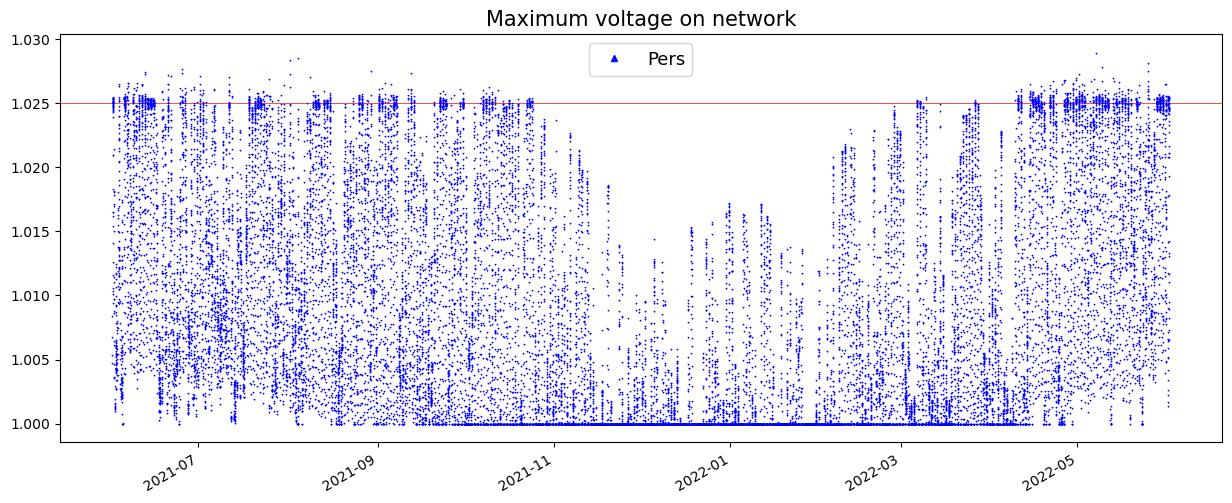

In [61]:
fig, axx = plt.subplots(figsize=(15,6), dpi=100)
plt.axhline(vm_mu_max,color='r', lw=0.5)

max_vm_pu_per_df.plot(style = ['b^'],markersize=0.5, ax=axx)
plt.legend( fontsize=13, markerscale=10)
plt.title("Maximum voltage on network", fontsize=15);

#### Setting up variables

In [80]:
extracted_results.loc[per_index2].P0100.values

array([0.59 , 0.652, 0.826, ..., 0.833, 0.672, 0.672])

In [87]:
P0100_df = df_final.loc[per_index2, ['P0100']]
P0100_pers_df = pd.DataFrame(data=extracted_results.loc[per_index2].P0100.values, 
                             index=extracted_results.loc[per_index2].index, 
                             columns=['Pers'] )
# Concat
P0100_concat_df = pd.concat([P0100_df,P0100_pers_df], axis=1)

# Rename
P0100_concat_df.rename(columns=({'P0100':'No_Control'}), inplace=True);

<AxesSubplot:>

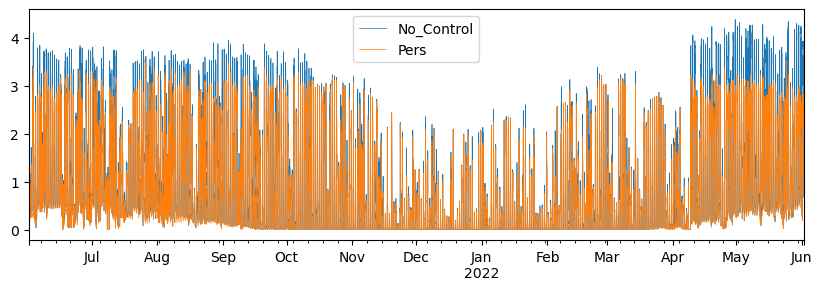

In [89]:
P0100_concat_df.plot(figsize=(10,3), lw=0.5)

In [91]:
# Compute Energy
var_no_control, var_Persistence = P0100_concat_df.sum()*Δt

print(f'P0100 prod,   No Control  : {var_no_control:.2f} MWh')
print(f'P0100 prod, Future known  : {var_Persistence:.2f} MWh |  Perc = {var_Persistence*100/var_no_control:.2f}%')


P0100 prod,   No Control  : 5229.63 MWh
P0100 prod, Future known  : 4492.81 MWh |  Perc = 85.91%


##### Save Variables
*<span style='color:green'>Run the following cell only one </span>*

In [96]:
var_to_save = dict({'P0100_concat_df':P0100_concat_df,
                    'voltage_rise_df':max_vm_pu_per_df, 
                    'Out_blocProd': extracted_results.loc[per_index2]# Where out bloc prod is the result 
                                                        # of the prediction using the persistence model 
                                                        # and the corresponding OPF voltage rise
                   })

joblib.dump(var_to_save,'pickle_files/simulationResults/Persistence.pkl')


['pickle_files/simulationResults/Persistence.pkl']

Controller stopped: {'exit_code': 15, 'pid': 15144, 'identifier': 'ipcontroller-1664542742-10y3-24920'}
Stopping engine(s): 1664542743
engine set stopped 1664542743: {'engines': {'0': {'exit_code': 15, 'pid': 4496, 'identifier': '0'}, '4': {'exit_code': 15, 'pid': 4772, 'identifier': '4'}, '3': {'exit_code': 15, 'pid': 18964, 'identifier': '3'}, '1': {'exit_code': 15, 'pid': 14224, 'identifier': '1'}, '6': {'exit_code': 15, 'pid': 19388, 'identifier': '6'}, '5': {'exit_code': 15, 'pid': 1700, 'identifier': '5'}, '2': {'exit_code': 15, 'pid': 24596, 'identifier': '2'}}, 'exit_code': 15}


Stopping cluster <Cluster(cluster_id='1664542742-10y3', profile='default', controller=<after>, engine_sets=['1664542743'])>
